In [126]:
import pandas as pd
import numpy as np
from stratified_dataset import ParallelStratifiedSynthesizer
from snsynth.mst import MSTSynthesizer
from snsynth.aim import AIMSynthesizer
from gem_synthesizer import GEMSynthesizer
import dill
from data_utils import get_employment
import itertools
import os
from IPython.display import clear_output
from stratified_dataset import StratifiedDataset
import torch
all_data, features, target, group = get_employment()

def load_pickled_model(filename, torch=False):
    with open(filename, "rb") as file:
        model = dill.load(file)
    return model

['RELP']


In [2]:
def calculate_dimensionality(df):
    dimensionality = 1
    for col in df.columns:
        unique_values = df[col].nunique()
        dimensionality *= unique_values
    return dimensionality

data_dimensionality = calculate_dimensionality(all_data)
print("Dimensionality of the data:", data_dimensionality)

Dimensionality of the data: 777600000


In [3]:
df = all_data.copy()
df = df.drop(columns=['CIT', 'MIG', 'DEAR', 'DEYE', 'NATIVITY', 'ANC'])

data_dimensionality = calculate_dimensionality(df)
print("Dimensionality of the data:", data_dimensionality)

Dimensionality of the data: 1215000


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Assuming 'all_data' dataframe is already defined
df = all_data.copy()

df = df.drop(columns=['CIT', 'MIG', 'DEAR', 'DEYE', 'NATIVITY', 'ANC'])

def train_on_df(df):
    # Target column
    target_col = 'ESR'

    # Feature columns
    feature_cols = [col for col in df.columns if col != target_col]

    # Convert all columns to categorical
    for col in df.columns:
        df[col] = df[col].astype('category')

    # Prepare the dataset
    X = df[feature_cols]
    y = df[target_col]

    # Split the dataset into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = clf.predict(X_test)

    # Evaluate the model
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy:", acc)
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # Find the most influential features
    importances = clf.feature_importances_
    feature_importances = sorted(zip(feature_cols, importances), key=lambda x: x[1], reverse=True)

    print("Feature importances:")
    for feature, importance in feature_importances:
        print(f"{feature}: {importance}")
    
    return acc

accuracy_overall = train_on_df(df)

Accuracy: 0.7938264710361984

Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      0.78      0.80     20971
         1.0       0.76      0.81      0.79     18423

    accuracy                           0.79     39394
   macro avg       0.79      0.80      0.79     39394
weighted avg       0.80      0.79      0.79     39394

Feature importances:
AGEP: 0.43235175354485184
SCHL: 0.23475111645036695
DIS: 0.10102305002883707
MIL: 0.07064120601923872
ESP: 0.046742781409869184
MAR: 0.03916345569503386
DREM: 0.03020780939002446
RAC1P: 0.0256614369739042
SEX: 0.01945739048787377


In [5]:
# TODO: Stratified public synthesizers

# Randomly shuffle the indices of the dataframe
# shuffled_indices = np.random.permutation(df.index)

# Split the shuffled dataframe into two equal parts
# half = len(df) // 2
# public_df = df.iloc[shuffled_indices[half:]]
# df = df.iloc[shuffled_indices[:half]]

In [6]:
# List of column names you want to use
cols = ['SEX', 'RAC1P'] #, 'DIS', 'AGEP']

# Generate all possible combinations of the given column names
combinations = []
for i in range(1, len(cols) + 1):
    combinations.extend(list(itertools.combinations(cols, i)))

In [7]:
# Make models directory if one doesnt exist
# NOTE: this code block is dangerous!
training = False
if training:
    if not os.path.exists("models"):
        os.mkdir("models")

    # Make log text file
    log_filename = "models/log.txt"
    log_path = os.path.join(os.getcwd(), log_filename)
    if not os.path.exists(log_path):
        with open(log_filename, "w") as file:
            file.write("")

    def fit_vanilla_model(model, epsilon, df):
        model_filename = f"models/{model.__name__}_epsilon_{epsilon}.dill"
        
        model_path = os.path.join(os.getcwd(), model_filename)
        if os.path.exists(model_path):
            print(f"Model {model_filename} already exists. Skipping.")
            return
        
        m = model(epsilon=epsilon)
        m.fit(df)
        with open(model_filename, "wb") as file:
            dill.dump(m, file)

    synthesizers = [MSTSynthesizer, AIMSynthesizer, GEMSynthesizer] #, MSTSynthesizer, AIMSynthesizer]

    # Epsilon values to try
    epsilons = [0.01, 0.05, 0.1, 0.5, 1.0, 5.0]

    for synth_class in synthesizers:
        for epsilon in epsilons:
            print(f"Training vanilla Synthesizer with {synth_class.__name__} and epsilon = {epsilon}")
            try:
                fit_vanilla_model(synth_class, epsilon, df)
            except:
                print(f"Failed to fit vanilla Synthesizer with {synth_class.__name__} with epsilon = {epsilon}")
                # Add to a log that we failed to fit this model
                with open(log_filename, "a") as file:
                    file.write(f"Failed to fit vanilla Synthesizer with {synth_class.__name__} with epsilon = {epsilon}\n")

            for combination in list(combinations):
                strata_cols = list(combination)
                
                print(f"Training ParallelStratifiedSynthesizer with {synth_class.__name__} and epsilon = {epsilon}")

                name_combo = str("_".join(combination))
                model_filename = f"models/{synth_class.__name__}_epsilon_{epsilon}_{name_combo}.dill"
                
                # Check if the model file already exists, and if so, skip training and pickling
                model_path = os.path.join(os.getcwd(), model_filename)
                if os.path.exists(model_path):
                    print(f"Model {model_filename} already exists. Skipping.")
                    continue

                clear_output(wait=True)

                # Split the dataframe into train set
                train_df, _ = train_test_split(df, test_size=0.2, random_state=42)
                try:
                    stratified_synth = ParallelStratifiedSynthesizer(synth_class, epsilon=epsilon)
                    stratified_synth.fit(df, strata_cols=strata_cols, categorical_columns=df.columns)

                    # Pickle the trained model
                    with open(model_filename, "wb") as file:
                        dill.dump(stratified_synth, file)
                    
                    print(f"Model saved as {model_filename}")
                except:
                    print(f"Failed to fit ParallelStratifiedSynthesizer with {synth_class.__name__} with epsilon = {epsilon} and strata_cols = {strata_cols}")
                    # Add to a log that we failed to fit this model
                    with open(log_filename, "a") as file:
                        file.write(f"Failed to fit ParallelStratifiedSynthesizer with {synth_class.__name__} with epsilon = {epsilon} and strata_cols = {strata_cols}\n")
                
                

    print("All models trained and pickled.")

In [118]:
def evaluate_on_dataframes(train_df, test_df, target_col = 'ESR'):
    # Feature columns
    feature_cols = [col for col in train_df.columns if col != target_col]

    # Convert all columns to categorical
    for col in train_df.columns:
        train_df[col] = train_df[col].astype('category')
    
    for col in test_df.columns:
        test_df[col] = test_df[col].astype('category')

    # Prepare the dataset
    X_train = train_df[feature_cols]
    y_train = train_df[target_col]
    X_test = test_df[feature_cols]
    y_test = test_df[target_col]

    # Train the classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = clf.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

def evaluate_worst_accuracy(train_df, test_df, strata_cols, target_col = 'ESR'):
    # Feature columns
    feature_cols = [col for col in train_df.columns if col != target_col]

    # Convert all columns to categorical
    for col in train_df.columns:
        train_df[col] = train_df[col].astype('category')
    
    for col in test_df.columns:
        test_df[col] = test_df[col].astype('category')

    # Create subgroups for train_df and test_df using strata_cols
    train_groups = train_df.groupby(strata_cols)
    test_groups = test_df.groupby(strata_cols)

    accuracies = []

    for train_key, train_group in train_groups:
        # try:
        print(train_key)
        test_group = test_groups.get_group(train_key)
        # except KeyError:
        #     print(f"No test group found for key: {train_key}")
        #     continue
        
        X_train = train_group[feature_cols]
        y_train = train_group[target_col]
        X_test = test_group[feature_cols]
        y_test = test_group[target_col]

        # Train the classifier
        clf = RandomForestClassifier(n_estimators=100, random_state=42)
        clf.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = clf.predict(X_test)

        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    # Return the worst accuracy
    return min(accuracies)

In [93]:
def disparate_impact_1(X, subgroups_synth, f, M_f):
    """
    Calculate the disparate impact (DI) of a differentially private function M_f.
    
    Args:
    stratified_dataset (StratifiedDataset): A StratifiedDataset object containing the dataset and protected subgroups.
    f (Callable): A non-private function mapping from X* to real numbers.
    M_f (Callable): A differentially private function mapping from X* to real numbers.
    
    Returns:
    float: The disparate impact of M_f.
    """
    k = len(subgroups_synth)  # Number of protected subgroups
    total_diff = 0
    for i in range(k):
        for j in range(k):
            diff_i = np.abs(f(X) - M_f(subgroups_synth[i]))
            diff_j = np.abs(f(X) - M_f(subgroups_synth[j]))
            total_diff += np.abs(diff_i - diff_j)

    DI_M_f = total_diff / (k * k * f(X))

    return DI_M_f

def disparate_impact_over_synth_data(true_X, synth_df, di_func=disparate_impact_1, smoke_test=False):
    results_df = {}

    # Short circuit if smoke testing
    if smoke_test:
        for combination in list(combinations):
            strata_cols = list(combination)
            results_df[str(strata_cols)] = 0
        return results_df
    
    for combination in list(combinations):
        strata_cols = list(combination)
        stratified_synth_df = StratifiedDataset(synth_df, strata_cols, categorical_columns=synth_df.columns)
        subgroups = stratified_synth_df.get_strata_dfs()
        di_standard = di_func(true_X,
                              subgroups,
                              lambda x: np.mean(x['ESR'].astype(float)),
                              lambda x: np.mean(x['ESR'].astype(float)))
        results_df[str(strata_cols)] = di_standard
    return results_df
    
# di_standard = disparate_impact_over_synth_data(true_X=real_test_df, synth_df=synth_df)

In [119]:
def get_subgroup_key(group, groupby_cols):
    key = []
    for col in groupby_cols:
        unique_values = group[col].unique()
        if len(unique_values) == 1:
            key.append((col, unique_values[0]))
        else:
            print(f"More than one unique value found for column '{col}' in the given group.")
            print(f"Unique values found: {unique_values}")
            print(f"Group:\n{group}")
            raise ValueError(f"More than one unique value found for column '{col}' in the given group.")
    return tuple(key)

def create_subgroups_dict(X, groupby_cols):
    subgroups = {}
    for _, group in X.groupby(groupby_cols):
        if not group.empty:
            key = get_subgroup_key(group, groupby_cols)
            subgroups[key] = group
        else:
            print('This weird thing happens sometimes where a group is empty. Not sure why.')
    return subgroups
    
def parity_error_synth_data(X, X_prime, groupby_cols, f, omega):
    subgroups_real = create_subgroups_dict(X, groupby_cols)
    subgroups_synth = create_subgroups_dict(X_prime, groupby_cols)
    f_values_real = []
    f_values_synth = []

    # Calculate f and M values for each stratum
    # for key in keys_for_comparison:
    for key, s in subgroups_real.items():
        s = subgroups_real[key]
        f_value_real = f(s)
        f_values_real.append(f_value_real)
        
        if key in subgroups_synth:
            f_value_synth = f(subgroups_synth[key])
        else:
            print(subgroups_synth)
            raise ValueError(f'Should not happen: {key} not in subgroups_synth')
            f_value_synth = f(X_prime)

        f_values_synth.append(f_value_synth)

    # Calculate the global f and M values
    f_global = f(X)
    f_synth_global = f(X_prime)

    # Compute the parity error
    beta = omega * (abs(f_global - f_synth_global) / f_global) + sum([(abs(t - s) / t) for t, s in zip(f_values_real, f_values_synth)])

    return beta

# Define the groupby columns
strata_cols = ['SEX', 'RAC1P']

# Calculate the parity error
omega = 0.2
# error = parity_error_synth_data(df, synth_df, strata_cols, f, omega)
# print("Parity error:", error)

In [120]:
def mean_f(df):#, col='ESR'):
    return df.astype(float).mean().values

# def mean_f(df):#, col='ESR'):
#     return df.astype(float).mean().values

def add_row_to_performance_df(performance_df, synth_class, synth_df, epsilon, real_train_df, real_test_df, name_combo, omega = 0.2):
    accuracy = evaluate_on_dataframes(synth_df, real_test_df)
    row_dict = {
        'Synthesizer': synth_class.__name__ + "_" + name_combo,
        'Epsilon': epsilon,
        'Accuracy': accuracy,
    }
    for combination in combinations:
        strata_cols = list(combination)
        # TODO: Fix worst_accuracy 
        # worst_accuracy = evaluate_worst_accuracy(synth_df, real_test_df, strata_cols)
        # row_dict['Worst_Accuracy_' + str(strata_cols)] = worst_accuracy
        parity_error = parity_error_synth_data(real_train_df, synth_df, strata_cols, mean_f, omega)
        row_dict[str(strata_cols)] = parity_error
    performance_df = performance_df.append(row_dict, ignore_index=True)
    return performance_df

In [123]:
import seaborn as sns
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
seed = 0

synthesizers = [GEMSynthesizer] #[MSTSynthesizer, AIMSynthesizer]
epsilons = [0.01, 0.05, 0.1, 0.5, 1.0, 5.0]
omega = 1/12 # (1/k is the default value in the paper)

def force_data_categorical_to_numeric(df, cat_columns=[]):
    # convert columns to categorical if they are not already
    for col in cat_columns:
        if col in df.columns:
            df[col] = df[col].astype('category')
            df[col] = df[col].cat.codes
    return df

def evaluate_model(model_filename, synth_class, epsilon, real_train_df, real_test_df, name_combo, omega):
    model = load_pickled_model(model_filename)
    synth_df = model.sample(real_train_df.shape[0])
    # NOTE: double forcing here, sort by synth_class_name or add vanilla tag
    if name_combo == "vanilla":
        synth_df = force_data_categorical_to_numeric(synth_df, cat_columns=synth_df.columns)
    performance_df = add_row_to_performance_df(pd.DataFrame(), synth_class, synth_df, epsilon, real_train_df, real_test_df, name_combo, omega)
    return performance_df

def determine_limiting_synth(real_train_df, real_test_df, synthesizers, epsilon=0.1, strata_cols=['SEX','RAC1P'], seed=0):
    smallest_intersection = None
    for synth_class in synthesizers:
        for combination in combinations:
            name_combo = str("_".join(combination))
            model_filename = f"models/{synth_class.__name__}_epsilon_{epsilon}_{name_combo}_seed_{seed}.dill"
            synth_df = load_pickled_model(model_filename).sample(100000)
            intersection = set(create_subgroups_dict(real_train_df, ['SEX', 'RAC1P']).keys()).intersection(set(create_subgroups_dict(synth_df, ['SEX', 'RAC1P']).keys()))
            print("Intersection: ", len(intersection))
            if smallest_intersection is None or len(intersection) < len(smallest_intersection):
                smallest_intersection = intersection
    real_train_df = real_train_df.loc[real_train_df.apply(lambda row: (('SEX', row['SEX']), ('RAC1P', row['RAC1P'])) in smallest_intersection, axis=1)]
    real_test_df = real_test_df.loc[real_test_df.apply(lambda row: (('SEX', row['SEX']), ('RAC1P', row['RAC1P'])) in smallest_intersection, axis=1)]
    print("Smallest intersection: ", len(smallest_intersection))
    return real_train_df, real_test_df

def generate_performance_plots(real_train_df, real_test_df, combinations, synthesizers, epsilons):
    dataframe_cols = ['Synthesizer', 'Epsilon', 'Accuracy']
    for combination in list(combinations):
        strata_cols = list(combination)
        dataframe_cols.append(str(strata_cols))
    performance_df = pd.DataFrame(columns=dataframe_cols)

    # We want to only fit on rows that are represented by all synthesizers
    real_train_df, real_test_df = determine_limiting_synth(real_train_df, real_test_df, synthesizers)

    with ThreadPoolExecutor() as executor:
        futures = []

        for synth_class in synthesizers:
            for epsilon in epsilons:
                model_filename = f"models/{synth_class.__name__}_epsilon_{epsilon}_seed_{seed}.dill"
                futures.append(executor.submit(evaluate_model, model_filename, synth_class, epsilon, real_train_df, real_test_df, "vanilla", omega))

                for combination in combinations:
                    name_combo = str("_".join(combination))
                    model_filename = f"models/{synth_class.__name__}_epsilon_{epsilon}_{name_combo}_seed_{seed}.dill"
                    futures.append(executor.submit(evaluate_model, model_filename, synth_class, epsilon, real_train_df, real_test_df, name_combo, omega))

        for future in tqdm(as_completed(futures), total=len(futures)):
            result_df = future.result()
            performance_df = performance_df.append(result_df, ignore_index=True)

    performance_df.to_pickle('performance_df.pkl')

    return performance_df


In [124]:
# Prepare the real dataset for evaluation
df_numeric = force_data_categorical_to_numeric(df, cat_columns=df.columns)
X_real = df_numeric.drop('ESR', axis=1)
y_real = df_numeric['ESR']
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(X_real, y_real, test_size=0.2, random_state=42)
train_df_real = X_train_real.copy()
train_df_real['ESR'] = y_train_real
test_df_real = X_test_real.copy()
test_df_real['ESR'] = y_test_real

# Generate the performance plots
performance_df = generate_performance_plots(train_df_real, test_df_real, list(combinations), synthesizers, epsilons)

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [111]:
performance_df

,Synthesizer,Epsilon,Accuracy,['SEX'],['RAC1P'],"['SEX', 'RAC1P']"
0,MSTSynthesizer_vanilla,0.05,0.759518,"[0.10040518848008768, 0.010574404770861722, 0....","[0.828890749767471, 0.34995711602303364, 0.367...","[1.8260958742723032, 0.7136310995379453, 0.852..."
1,MSTSynthesizer_vanilla,0.10,0.762949,"[0.08232672573603278, 0.010260093422180618, 0....","[0.49876672996505406, 0.35751724325753304, 0.2...","[1.0974734550715477, 0.7516052703262766, 0.603..."
2,MSTSynthesizer_vanilla,0.01,0.757129,"[0.07642962623952505, 0.015849628119398843, 0....","[0.9416217263820148, 0.4771879160370481, 0.458...","[1.9159727444456123, 0.9623417831063614, 0.958..."
3,MSTSynthesizer_SEX,0.01,0.746963,"[0.03197331687718931, 0.05138830703758099, 0.0...","[0.8782018684193309, 0.4289621159947876, 1.021...","[3.015361353627517, 1.1525722981749043, 2.6499..."
4,MSTSynthesizer_SEX,0.05,0.762619,"[0.0122931004820232, 0.007038571131396722, 0.0...","[0.9146472748818723, 0.42142140867962735, 0.75...","[1.9594693246176431, 1.472195660201384, 1.4642..."
5,MSTSynthesizer_SEX,0.10,0.761526,"[0.004804761291293522, 0.00585045218741023, 0....","[0.6093529299160259, 0.25320569180304225, 0.27...","[1.4470952748402963, 0.96725306534985, 0.86931..."
6,MSTSynthesizer_RAC1P,0.10,0.758603,"[0.6469119157117937, 0.33655987586240776, 0.78...","[0.40589219701443063, 0.27406156590944614, 0.2...","[1.334938917636486, 0.8272172208156413, 0.8094..."
7,MSTSynthesizer_RAC1P,0.01,0.679129,"[0.15058499099437048, 0.12494682873910364, 0.0...","[2.1080998761887333, 1.080471117620114, 1.2571...","[4.22888977842494, 2.1358802124317955, 2.49514..."
8,MSTSynthesizer_RAC1P,0.05,0.747115,"[0.16325202219438356, 0.061244222212266344, 0....","[0.7589267572620614, 0.5141544195888855, 0.365...","[1.945424794732358, 1.0612191747136317, 0.8968..."
9,MSTSynthesizer_SEX_RAC1P,0.10,0.752198,"[0.21622617066467348, 0.11661172951834547, 0.2...","[1.0465649019326366, 0.42330569323937584, 0.46...","[1.822847038580131, 0.7480014435163481, 0.9392..."


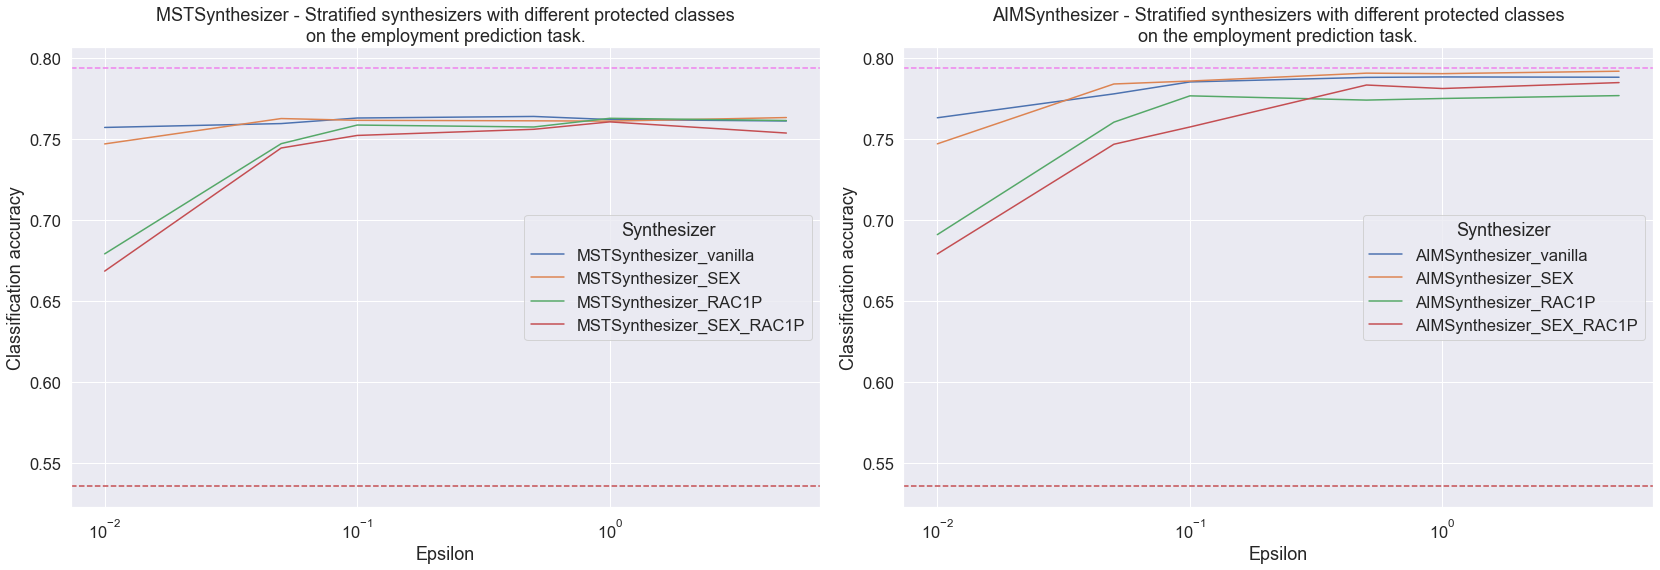

In [114]:
def plot_performance_synths_all_one_plot(performance_df, overall_accuracy):
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.set(font_scale=1.5)
    # add baseline performance horizontal line at specific y value
    baseline = max(df['ESR'].value_counts() / len(df))
    plt.axhline(y=baseline, color='r', linestyle='--')
    plt.axhline(y=overall_accuracy, color='violet', linestyle='--')
    sns.lineplot(data=performance_df, x='Epsilon', y='Accuracy', hue='Synthesizer')
    plt.xlabel("Epsilon")
    plt.ylabel("Classification accuracy")
    plt.title("Stratified synthesizers with different protected classes \n on the employment prediction task.")
    plt.xscale('log')
    plt.show()

def plot_performance_synths_subplots(performance_df, overall_accuracy):
     # Extract unique synthesizer prefixes
    prefixes = performance_df['Synthesizer'].apply(lambda x: x.split('_')[0]).unique()
    
    # Create subplots
    num_prefixes = len(prefixes)
    fig, axes = plt.subplots(nrows=1, ncols=num_prefixes, figsize=(11.7 * num_prefixes, 8.27))
    
    sns.set(font_scale=1.5)
    
    for idx, (prefix, ax) in enumerate(zip(prefixes, axes.flatten())):
        filtered_data = performance_df[performance_df['Synthesizer'].str.startswith(prefix)]
        
        # Add baseline performance horizontal line at specific y value
        baseline = max(df['ESR'].value_counts() / len(df))
        ax.axhline(y=baseline, color='r', linestyle='--')
        ax.axhline(y=overall_accuracy, color='violet', linestyle='--')
        sns.lineplot(data=filtered_data, x='Epsilon', y='Accuracy', hue='Synthesizer', ax=ax)
        ax.set_xlabel("Epsilon")
        ax.set_ylabel("Classification accuracy")
        ax.set_title(f"{prefix} - Stratified synthesizers with different protected classes\non the employment prediction task.")
        ax.set_xscale('log')
        # ax.get_legend().remove()
    
    # Create a single legend for the overall figure
    # handles, labels = ax.get_legend_handles_labels()
    # fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1, 1), title='Synthesizers')
    
    plt.tight_layout()
    plt.show()

# load performance_df
performance_df = pd.read_pickle('performance_df.pkl')
plot_performance_synths_subplots(performance_df, overall_accuracy=accuracy_overall)

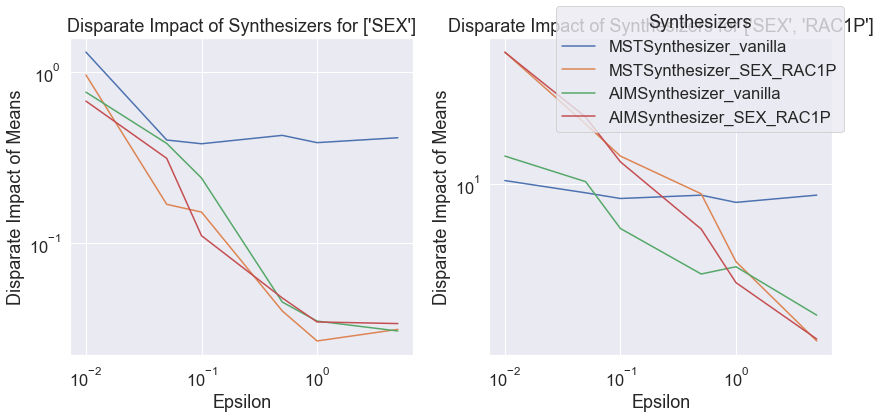

In [117]:
def plot_disparate_impact_subplots_strata_only_limited(performance_df, function_name):
    intersectional_groups = ["['SEX']", "['SEX', 'RAC1P']"]
    synth_filters = {
        "['SEX']": ['AIMSynthesizer_vanilla', 'AIMSynthesizer_SEX',
                    'MSTSynthesizer_vanilla', 'MSTSynthesizer_SEX'],
        "['SEX', 'RAC1P']": ['AIMSynthesizer_vanilla', 'AIMSynthesizer_SEX_RAC1P',
                             'MSTSynthesizer_vanilla', 'MSTSynthesizer_SEX_RAC1P'],
    }
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    
    for idx, (group, ax) in enumerate(zip(intersectional_groups, axes)):
        relevant_synths = synth_filters[group]
        filtered_data = performance_df[performance_df['Synthesizer'].isin(relevant_synths)]
        
        data = filtered_data[['Synthesizer', 'Epsilon', group]]
        data = data.rename(columns={group: 'Disparate Impact'})
        data['Intersectional Group'] = group
        data['Disparate Impact'] = data['Disparate Impact'].apply(lambda x: sum(x[~np.isnan(x)]))
        sns.lineplot(x='Epsilon', y='Disparate Impact', hue='Synthesizer', data=data, ax=ax)
        ax.set_title(f"Disparate Impact of Synthesizers for {group}")
        ax.set_xlabel('Epsilon')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylabel('Disparate Impact of ' + function_name)
        ax.get_legend().remove()
    
    # Create a single legend for the overall figure
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1, 1), title='Synthesizers')
    
    plt.tight_layout()
    plt.show()
plot_disparate_impact_subplots_strata_only_limited(performance_df, function_name='Means')

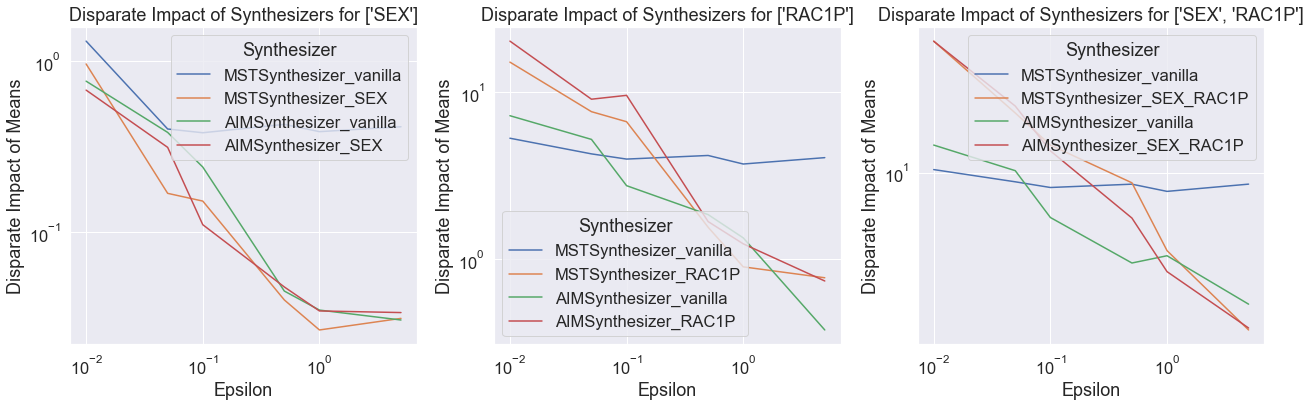

In [115]:
def plot_disparate_impact_subplots_strata_only(performance_df, function_name):
    intersectional_groups = ["['SEX']", "['RAC1P']", "['SEX', 'RAC1P']"]
    synth_filters = {
        "['SEX']": ['AIMSynthesizer_vanilla', 'AIMSynthesizer_SEX',
                    'MSTSynthesizer_vanilla', 'MSTSynthesizer_SEX'],
        "['RAC1P']": ['AIMSynthesizer_vanilla', 'AIMSynthesizer_RAC1P',
                      'MSTSynthesizer_vanilla', 'MSTSynthesizer_RAC1P'],
        "['SEX', 'RAC1P']": ['AIMSynthesizer_vanilla', 'AIMSynthesizer_SEX_RAC1P',
                             'MSTSynthesizer_vanilla', 'MSTSynthesizer_SEX_RAC1P'],
    }
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
    
    for idx, (group, ax) in enumerate(zip(intersectional_groups, axes)):
        relevant_synths = synth_filters[group]
        filtered_data = performance_df[performance_df['Synthesizer'].isin(relevant_synths)]
        
        data = filtered_data[['Synthesizer', 'Epsilon', group]]
        data = data.rename(columns={group: 'Disparate Impact'})
        data['Intersectional Group'] = group
        data['Disparate Impact'] = data['Disparate Impact'].apply(lambda x: sum(x[~np.isnan(x)]))
        sns.lineplot(x='Epsilon', y='Disparate Impact', hue='Synthesizer', data=data, ax=ax)
        ax.set_title(f"Disparate Impact of Synthesizers for {group}")
        ax.set_xlabel('Epsilon')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylabel('Disparate Impact of ' + function_name)
        # ax.get_legend().remove()
    
    # Create a single legend for the overall figure
    # handles, labels = ax.get_legend_handles_labels()
    # fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1, 1), title='Synthesizers')
    
    plt.tight_layout()
    plt.show()
plot_disparate_impact_subplots_strata_only(performance_df, function_name='Means')

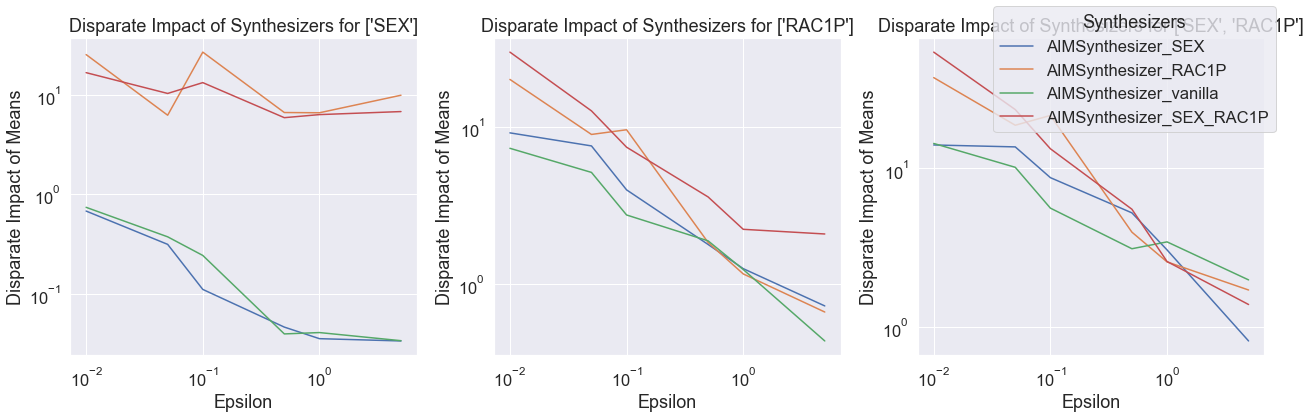

In [82]:
def plot_disparate_impact_subplots(performance_df, function_name):
    intersectional_groups = ["['SEX']", "['RAC1P']", "['SEX', 'RAC1P']"]
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
    
    for idx, (group, ax) in enumerate(zip(intersectional_groups, axes)):
        data = performance_df[['Synthesizer', 'Epsilon', group]]
        data = data.rename(columns={group: 'Disparate Impact'})
        data['Intersectional Group'] = group
        data['Disparate Impact'] = data['Disparate Impact'].apply(lambda x: sum(x[~np.isnan(x)]))
        # print(data)
        sns.lineplot(x='Epsilon', y='Disparate Impact', hue='Synthesizer', data=data, ax=ax)
        ax.set_title(f"Disparate Impact of Synthesizers for {group}")
        ax.set_xlabel('Epsilon')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylabel('Disparate Impact of ' + function_name)
        ax.get_legend().remove()
    
    # Create a single legend for the overall figure
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1, 1), title='Synthesizers')
    
    plt.tight_layout()
    plt.show()


# Call the function with your performance_df
plot_disparate_impact_subplots(performance_df, function_name='Means')
# 

In [39]:
with open('models/MSTSynthesizer_epsilon_5.0_SEX_RAC1P_seed_0.dill', "rb") as file:
    model = dill.load(file)

In [36]:
# iterate through all models in models folder,
# load them, and sample 10 rows
for filename in os.listdir('models'):
    if filename.endswith('.dill'):
        try:
            model = load_pickled_model(f'models/{filename}')
            synth_df = model.sample(1000)
            # print(synth_df.head())
            # print('SUCCESS\n')
        except Exception as e:
            print(f'Failed to load {filename}')
            print(e)
            continue
            

In [5]:
stratified_synth_aim = ParallelStratifiedSynthesizer(MSTSynthesizer, epsilon=0.1)
stratified_synth_aim.fit(df, strata_cols=['RAC1P'], categorical_columns=df.columns)

Fitting synthesizer on strata with sizeFitting synthesizer on strata with size 10964
 138474
Fitting synthesizer on strata with size 17030
Fitting synthesizer on strata with size Fitting synthesizer on strata with size5646 24024Fitting synthesizer on strata with size

Fitting synthesizer on strata with size 244 
508


In [8]:
df

,AGEP,SCHL,MAR,DIS,ESP,MIL,DREM,SEX,RAC1P,ESR
0,1,4,5.0,2.0,0.0,4.0,2.0,2.0,1.0,0.0
1,1,4,5.0,2.0,0.0,4.0,2.0,1.0,1.0,1.0
2,0,3,5.0,2.0,0.0,4.0,2.0,2.0,8.0,0.0
3,4,3,2.0,1.0,0.0,4.0,1.0,2.0,1.0,0.0
4,0,3,5.0,2.0,0.0,4.0,2.0,2.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
196962,1,4,1.0,2.0,0.0,4.0,2.0,1.0,6.0,1.0
196963,0,0,5.0,2.0,1.0,0.0,0.0,2.0,9.0,0.0
196964,1,4,5.0,2.0,0.0,4.0,2.0,1.0,1.0,1.0
196965,2,4,1.0,2.0,0.0,4.0,2.0,1.0,1.0,1.0


In [10]:
stratified_synth_aim.strata_synthesizers[1].sample(10)

/Users/lucasrosenblatt/opt/miniconda3/envs/heuristic_fairness/lib/python3.8/site-packages/mbi/graphical_model.py:246: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df = df.groupby(list(proj)).apply(foo)
/Users/lucasrosenblatt/opt/miniconda3/envs/heuristic_fairness/lib/python3.8/site-packages/mbi/graphical_model.py:246: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior

,AGEP,SCHL,MAR,DIS,ESP,MIL,DREM,SEX,RAC1P,ESR
0,1,4,1,1,4,0,0,1,2,0
1,0,2,4,0,2,0,2,1,2,1
2,4,3,4,1,5,3,2,1,2,0
3,2,3,0,0,4,3,0,1,2,1
4,0,4,1,1,5,4,2,0,2,0
5,3,4,2,1,4,0,2,0,2,1
6,1,1,1,1,7,4,2,0,2,0
7,4,4,2,1,4,3,2,1,2,1
8,1,0,4,1,1,3,2,1,2,1
9,1,4,1,0,8,3,1,1,2,1


In [13]:
# suppress warnings
import warnings
warnings.filterwarnings('ignore')
for i in range(len(stratified_synth_aim.strata_synthesizers)):
    print(len(stratified_synth_aim.strata_synthesizers[i].sample(10)))

10
10
10
10
10
10
10


In [22]:
samples = []
for strata_df, synthesizer in zip(stratified_synth_aim.stratified_dataset.get_strata_dfs(limit_size=True), stratified_synth_aim.strata_synthesizers):
    n = int(1000 * strata_df.shape[0] / stratified_synth_aim.stratified_dataset.df.shape[0])
    print(n)
    synthesizer.sample(1)
    #samples.append(synthesizer.sample(n))

703
55
86
28
121
1
2


In [128]:
stratified_synth.stratified_dataset.force_data_categorical_to_numeric(df).astype(float).describe()

,AGEP,SCHL,MAR,DIS,ESP,MIL,DREM,SEX,RAC1P,ESR
count,196967.000000,196967.000000,196967.000000,196967.000000,196967.000000,196967.000000,196967.000000,196967.000000,196967.000000,196967.000000
mean,1.687328,2.834246,3.042713,1.865262,0.543330,3.183203,1.851990,1.516863,2.185625,0.464387
std,1.234446,1.246443,1.867062,0.341445,1.587463,1.547406,0.471425,0.499717,2.341672,0.498731
min,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,1.000000,2.000000,1.000000,2.000000,0.000000,4.000000,2.000000,1.000000,1.000000,0.000000
50%,2.000000,3.000000,3.000000,2.000000,0.000000,4.000000,2.000000,2.000000,1.000000,0.000000
75%,3.000000,4.000000,5.000000,2.000000,0.000000,4.000000,2.000000,2.000000,2.000000,1.000000
max,4.000000,4.000000,5.000000,2.000000,8.000000,4.000000,2.000000,2.000000,9.000000,1.000000


In [134]:
stratified_synth_aim.sample(2000).describe()

,AGEP,SCHL,MAR,DIS,ESP,MIL,DREM,SEX,RAC1P,ESR
count,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000
mean,1.679340,2.824912,2.042021,0.863432,0.532766,3.170085,1.852426,0.483242,1.172086,0.465733
std,1.232984,1.252968,1.872362,0.343477,1.567565,1.554832,0.474297,0.499844,2.316845,0.498949
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,0.000000,1.000000,0.000000,4.000000,2.000000,0.000000,0.000000,0.000000
50%,2.000000,3.000000,2.000000,1.000000,0.000000,4.000000,2.000000,0.000000,0.000000,0.000000
75%,3.000000,4.000000,4.000000,1.000000,0.000000,4.000000,2.000000,1.000000,1.000000,1.000000
max,4.000000,4.000000,4.000000,1.000000,8.000000,4.000000,2.000000,1.000000,8.000000,1.000000


In [143]:
! pip install google-auth google-auth-oauthlib
! pip install google-api-python-client

     |████████████████████████████████| 11.3 MB 6.2 MB/s eta 0:00:01
     |████████████████████████████████| 96 kB 20.3 MB/s eta 0:00:01
  Using cached uritemplate-4.1.1-py2.py3-none-any.whl (10 kB)
     |████████████████████████████████| 120 kB 28.4 MB/s eta 0:00:01
  Using cached google_auth_httplib2-0.1.0-py2.py3-none-any.whl (9.3 kB)
     |████████████████████████████████| 223 kB 23.0 MB/s eta 0:00:01
     |████████████████████████████████| 178 kB 42.6 MB/s eta 0:00:01
     |████████████████████████████████| 397 kB 38.2 MB/s eta 0:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.0
    Uninstalling protobuf-3.20.0:
      Successfully uninstalled protobuf-3.20.0
  Attempting uninstall: google-auth
    Found existing installation: google-auth 2.6.2
    Uninstalling google-auth-2.6.2:
      Successfully uninstalled google-auth-2.6.2
